In [1]:
# Imports, check version 

import h5py
import numpy as np
from scipy import stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pickle
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import psutil
import resource
from collections import Counter
import itertools
import multiprocessing as mp
import os
import re
import sys
print(sys.version)

from sys import path
path.append('/mnt/smb/locker/issa-locker/users/Dan/code')
from data_analysis_tools_mkTurk.utils_meta import get_recording_path
from data_analysis_tools_mkTurk.general import df_2_psth_mat
from data_analysis_tools_mkTurk.IO import ch_dicts_2_h5, h5_2_trial_df, h5_2_df
from data_analysis_tools_mkTurk.npix import chs_meta_2_site_coords, h5_2_ch_meta
from mkutils_ddk.IO import sessions2spikes, find_h5_path

3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]


In [2]:
# Test: load an h5 file
pathname = '/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20240403_R_H01_P52/20240403.h5'
f = h5py.File(pathname)
list(f.keys())

['data',
 'imro_table',
 'stim_indices',
 'trial_params',
 'trial_params_short',
 'zero_coordinates']

In [3]:
# Define memory checking functions
def check_mem():
    # Current process memory usage
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024 / 1024
    print(f"Current process memory: {memory_mb:.2f} MB")
    
    # System memory info
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / 1024**3:.2f} GB")
    print(f"Available memory: {memory.available / 1024**3:.2f} GB")
    print(f"Memory usage: {memory.percent}%")

def check_rss():
    process = psutil.Process()
    rss_current = process.memory_info().rss / 1024**3
    print(f"Current RSS usage: {rss_current:.2f} GB")
    
    # Check the limit
    soft, hard = resource.getrlimit(resource.RLIMIT_RSS)
    print(f"RSS limit: {soft/1024**3:.2f} GB (soft), {hard/1024**3:.2f} GB (hard)")

def get_size(obj):
    size = sys.getsizeof(obj)
    if isinstance(obj, dict):
        size += sum([get_size(v) for v in obj.values()])
        size += sum([get_size(k) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i) for i in obj])
    
    return size

def check_mem_max():
    # Check various process limits
    limits_to_check = [
        (resource.RLIMIT_AS, "Virtual memory"),
        (resource.RLIMIT_DATA, "Data segment"),
        (resource.RLIMIT_RSS, "Resident set size"),
    ]
    
    for limit_type, name in limits_to_check:
        try:
            soft, hard = resource.getrlimit(limit_type)
            if soft != resource.RLIM_INFINITY:
                print(f"{name}: {soft / 1e9:.1f}GB (soft), {hard / 1e9:.1f}GB (hard)")
            else:
                print(f"{name}: Unlimited")
        except (ValueError, OSError):
            print(f"{name}: Not available on this system")

In [4]:
# Define functions for dates --> h5_paths and dataframe 

def h5_paths(monkey, dates):
    recording_prefix = '/mnt/smb/locker/issa-locker/users/Dan/ephys'
    monkey_pens = os.listdir(f'{recording_prefix}/{monkey}')
    date_2_pen = {date: [pen for pen in monkey_pens if date in pen] for date in dates}
    paths = [f'{recording_prefix}/{monkey}/{pen[0]}/{date}.h5' for date,pen in date_2_pen.items()]
    return paths

def sess_2_df(path, scenefiles, time_window):
    
    # Create filter for scenefiles
    trial_params = h5_2_trial_df(path)
    filter = trial_params.scenefile.isin(scenefiles)
    scenefile_trials = trial_params[filter]
    array_filter = np.array(scenefile_trials[['trial_num', 'rsvp_num']])
    
    # Read spike count data from HDF5 for requested trials:
    df = h5_2_df(path, trials=array_filter, time_window=time_window)
    
    # Sort df to match trial_params, rust_trials
    df.sort_index(inplace=True)
    
    return df

In [5]:
# Create 2x2 df of monkey/imageset --> dates 

pens_df = pd.DataFrame(columns=['Rust', 'HvM'], index=['West', 'Bourgeois'])

# West Rust
west_rust_dates = ['20231129', '20231130', '20240403']
pens_df.loc['West','Rust'] = west_rust_dates

# Bourgeois Rust

pens_list = ['axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241108_R_H00_P09/all_psth.h5',
'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241111_R_H00_P10/all_psth.h5',
'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241122_R_H00_P19/all_psth.h5',
'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241205_R_H00_P26/all_psth.h5',
'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241230_R_H00_P39/all_psth.h5']

bour_rust_dates = [path[87:95] for path in pens_list]
pens_df.loc['Bourgeois', 'Rust'] = bour_rust_dates

# West HvM

pens_list = ['axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20240912_R_H01_P73/all_psth.h5',
'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20240913_R_H01_P74/all_psth.h5',
'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20240923_R_H01_P76/all_psth.h5',
'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20241002_R_H01_P80/all_psth.h5',
'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20241008_R_H02_P38/all_psth.h5']

west_hvm_dates = [path[77:85] for path in pens_list]
pens_df.loc['West', 'HvM'] = west_hvm_dates

# Bourgeois HvM

pens_list = ['/Volumes/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241206_R_H00_P27/20241206.h5',
 '/Volumes/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241202_R_H00_P23/20241202.h5',
 '/Volumes/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241227_R_H00_P38/20241227.h5',
 '/Volumes/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241126_R_H00_P21/20241126.h5',
 '/Volumes/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241127_R_H00_P22/20241127.h5']

bour_hvm_dates = [path[57:65] for path in pens_list]
pens_df.loc['Bourgeois', 'HvM'] = bour_hvm_dates

pens_df

,Rust,HvM
West,"[20231129, 20231130, 20240403]","[20240912, 20240913, 20240923, 20241002, 20241..."
Bourgeois,"[20241108, 20241111, 20241122, 20241205, 20241...","[20241206, 20241202, 20241227, 20241126, 20241..."


In [6]:
# Create scenefile dict, prefix dict
imageset_to_scenefiles = {
    'Rust': ['/mkturkfiles/scenebags/West/20231025_Rust_NaturalImages300_300ms.json'],
    'Objaverse': ['/mkturkfiles/scenebags/West/neural_stim_4_0ABCDEFGHIJ.json'],
    'EliasNeptune': ['/mkturkfiles/scenebags/West/20231025_Var6vbslir_set0_im151_neptune_dur300ms_lab_updated.json',
       '/mkturkfiles/scenebags/West/20231025_Var6vbslir_set0_im151_elias_dur300ms_lab_updated.json'],
    'HvM': ['/mkturkfiles/scenebags/West/hvm10_table_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_elephant_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_dog_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_bear_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_chair_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_car_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_turtle_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_plane_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_apple_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_head_45_20240906.json']
}

# Set prefixes for imagesets (before scenefile names)
imageset_to_prefix = {
    'Rust': '/mnt/smb/locker/issa-locker/Data/West/Saved_Images/Saved_Images_West_neural_stim__RustDiCarlo_NaturalImages/Save_Images_West_RustDiCarlo/',
    'EliasNeptune': '/mnt/smb/locker/issa-locker/Data/West/Saved_Images/Saved_Images_West_neural_stim_EliasNeptune/Save_Images_West_EliasNeptune/',
    'HvM': '/mnt/smb/locker/issa-locker/Data/West/Saved_Images/hvm10/'
}

In [88]:
# Set analysis parameters
monkey = 'Bourgeois'
imageset = 'HvM'
start_bin = 0
end_bin = .301
cores = 6

notes = ''

In [ ]:
''' Best pens for each
Bour Rust: 20241122
West Rust: 20231129 ~200 (remaining pens are <5)
Bour HvM: all except 20241227 are ~150
West HvM: 20240912 + 20240913 (remaining pens are <5)
'''

In [90]:
# Choose monkey/imgset, scenefile, time window
dates = pens_df.loc[monkey, imageset]
paths = h5_paths(monkey, dates)
scenefiles = imageset_to_scenefiles[imageset]
time_window = [start_bin, end_bin] # in seconds

h5_df_columns = ['monkey', 'date', 'trial_num', 'rsvp_num', 'stim_id', 'stim_idx',
       'scenefile', 'behav_file', 'img_full_path', 'psth_bins', 'source_path',
       'psth']

print(dates)

['20241206', '20241202', '20241227', '20241126', '20241127']


In [91]:
# Get combined dataframe for sessions

combined_sess_df = pd.DataFrame(columns=h5_df_columns)

for path in paths:
    sess_df = sess_2_df(path, scenefiles, time_window)
    combined_sess_df = pd.concat([combined_sess_df, sess_df])
    print(f"Variable size: {get_size(combined_sess_df) / 1024**2:.2f} MB")
    check_rss()

combined_sess_df.shape

/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...
... done (0.04694938659667969 sec).
inds_df.shape = (10500, 2)
Pre-fetching PSTHs from HDF5...
... done.
Duration=0.09761325120925904 minutes
Fancy slicing numpy array...
... done.
Duration=0.09137047926584879 minutes
Variable size: 36.40 MB
Current RSS usage: 5.39 GB
RSS limit: 96.00 GB (soft), 96.00 GB (hard)


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...
... done (0.05328559875488281 sec).
inds_df.shape = (9258, 2)
Pre-fetching PSTHs from HDF5...
... done.
Duration=0.04804160992304484 minutes
Fancy slicing numpy array...
... done.
Duration=0.07823803424835205 minutes
Variable size: 68.44 MB
Current RSS usage: 6.45 GB
RSS limit: 96.00 GB (soft), 96.00 GB (hard)


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...
... done (0.05727720260620117 sec).
inds_df.shape = (9660, 2)


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Pre-fetching PSTHs from HDF5...
... done.
Duration=0.13658749262491862 minutes
Fancy slicing numpy array...
... done.
Duration=0.08285324970881144 minutes
Variable size: 101.87 MB
Current RSS usage: 7.55 GB
RSS limit: 96.00 GB (soft), 96.00 GB (hard)


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...
... done (0.03620553016662598 sec).
inds_df.shape = (9114, 2)
Pre-fetching PSTHs from HDF5...
... done.
Duration=0.045959595839182535 minutes
Fancy slicing numpy array...
... done.
Duration=0.07526306708653768 minutes
Variable size: 133.41 MB
Current RSS usage: 8.60 GB
RSS limit: 96.00 GB (soft), 96.00 GB (hard)


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...
... done (0.05276036262512207 sec).
inds_df.shape = (9018, 2)


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Pre-fetching PSTHs from HDF5...
... done.
Duration=0.18985309600830078 minutes
Fancy slicing numpy array...
... done.
Duration=0.07416675488154094 minutes
Variable size: 164.62 MB
Current RSS usage: 9.63 GB
RSS limit: 96.00 GB (soft), 96.00 GB (hard)


(47550, 12)

In [92]:
# Create + apply mask to remove nans
mask = combined_sess_df.apply(lambda x : np.all(np.isnan(x.psth)), axis=1)
final_df = combined_sess_df[-mask]
print(final_df.shape)

(41807, 12)


In [93]:
# Set prefix
prefix = imageset_to_prefix[imageset]

In [94]:
# Get paths without img_full_path

start_idx = 28 # based on '/mkturkfiles/scenebags/West/...'
final_df['spliced_scenefile'] = final_df['scenefile'].str.removesuffix('.json').str[start_idx:]

# Generate img_full_path
def png_path_end_int(path):
    match = re.search(r'(\d+)\.png$', path)
    if match:
        return int(match.group(1))  # Returns "123" as string
    else:
        return None

for scenefile in final_df['spliced_scenefile'].unique():
    sfile_path = prefix + scenefile
    img_list = os.listdir(sfile_path)
    # Note: there is one .json in each scenefile, which is mapped to None in dict
    idx_to_path = {png_path_end_int(img):'/'.join([sfile_path, img]) for img in img_list}
    scene_mask = final_df['spliced_scenefile'] == scenefile
    final_df.loc[scene_mask, 'img_full_path'] = final_df.loc[scene_mask, 'stim_idx'].map(idx_to_path) 

/tmp/ipykernel_289860/4193354413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['spliced_scenefile'] = final_df['scenefile'].str.removesuffix('.json').str[start_idx:]


In [95]:
def ch_shr(ch_data, path_list, min_repeats):
    ''' Gets the split-halves reliability for a single channel

    Args:
        ch_data (n by 1 array): ordered channel activity
        path_list: ordered image paths
        min_repeats: minimum repetitions required for an image to be used

    Returns:
        shr: split-halves reliability
        count_arr: matrix of max repetitions x image for the channel
    '''
    # ch_data --> count_arr using path_list
    path_counts = Counter(path_list)
    valid_paths = [path for path, count in path_counts.items() if count >= min_repeats]
    unique_imgs = set(valid_paths)
    img_count = len(unique_imgs)
    max_reps = max(path_counts[path] for path in valid_paths)
    count_arr = np.full((max_reps, img_count), np.nan)
    for unique_img_idx, path in enumerate(unique_imgs):
        idx_list = [i for i, j in enumerate(path_list) if j == path]
        np.random.shuffle(idx_list) # NOTE RANDOMNESS INTRODUCED!
        reps = len(idx_list)
        count_arr[:reps, unique_img_idx] = ch_data[idx_list]
    
    # Find SHR using count_arr
    neuron_1, neuron_2 = count_arr[::2], count_arr[1::2]
    neuron_1_avg = np.nanmean(neuron_1, axis=0)
    neuron_2_avg = np.nanmean(neuron_2, axis=0)
    shr, _ = stats.pearsonr(neuron_1_avg, neuron_2_avg)

    return shr, count_arr

In [ ]:
%%time #NOT PARALLEL
# Calculate SHRs:

trial_avg_list = []

folds = 1
min_repeat = 2
sh_limit = .3

date_to_reliable_ch = {}

for date in final_df.date.unique():
    print(f'Date: {date}')
    
    # Convert psth to spike matrix, sort by stim_idx to match other pens
    date_df = final_df[final_df['date'] == date].copy()
    date_df.sort_values(by='stim_idx', inplace=True)
    
    # Extract spikes, check for nan
    final_spike_arr = np.array(list(date_df.psth))
    
    # Create avg_spikes, zscore
    avg_spikes = np.mean(final_spike_arr, axis=2)
    marm_avg_spikes = zscore(avg_spikes.astype('float32'), axis=1)
    
    # Get natimg_path_list
    natimg_path_list = date_df['img_full_path'].tolist()
    
    # Find max_reps
    trial_counts = []
    for path in set(natimg_path_list):
        trial_counts.append(natimg_path_list.count(path))
    max_reps = max(trial_counts)
    
    # Set data parameters, folds, min_repeat
    ch_tot = marm_avg_spikes.shape[1]
    stim_tot = marm_avg_spikes.shape[0]
    
    # Get sh, img_spikes_tot
    sh_data = np.zeros(ch_tot)
    unique_img_count = len(set(natimg_path_list))
    #img_spikes_tot = np.zeros((folds, ch_tot, max_reps, unique_img_count))  (Deprecated img_spikes_tot)
    
    shr_arr = np.zeros((folds, ch_tot))
    
    for fold, ch in itertools.product(range(folds), range(ch_tot)):
        shr, count_arr = ch_shr(marm_avg_spikes[:, ch], natimg_path_list, min_repeat)
        shr_arr[fold, ch] = shr
        #img_spikes_tot[fold, ch] = count_arr
        if ch%50 == 0:
            print(f'Fold: {fold}, Channel: {ch}/{ch_tot}')
    
    sh_data = np.mean(shr_arr, axis=0)
    
    # Set sh minimum, get + save good channel idx
    good_ch = np.where(sh_data >= sh_limit)[0]
    good_ch_count = good_ch.shape[0]
    print(f'Number of good neurons: {good_ch_count}')
    date_to_reliable_ch[date] = good_ch
    
    #trial_avg_spikes = np.nanmean(img_spikes_tot[0], axis=1).T
    #trial_avg_list.append(trial_avg_spikes) # Consider editing this to remove img_spikes_tot...

In [111]:
%%time # Calculate SHRs:

trial_avg_list = []

folds = 1
min_repeat = 2
sh_limit = .3

date_to_reliable_ch = {}

def process_fold_channel(args):
    """Process a single fold-channel pair"""
    fold, ch, marm_avg_spikes, natimg_path_list, min_repeat = args
    shr, count_arr = ch_shr(marm_avg_spikes[:, ch], natimg_path_list, min_repeat)
    return fold, ch, shr

for date in final_df.date.unique():
    print(f'Date: {date}')
    
    # Convert psth to spike matrix, sort by stim_idx to match other pens
    date_df = final_df[final_df['date'] == date].copy()
    date_df.sort_values(by='stim_idx', inplace=True)
    
    # Extract spikes, check for nan
    final_spike_arr = np.array(list(date_df.psth))
    
    # Create avg_spikes, zscore
    avg_spikes = np.mean(final_spike_arr, axis=2)
    marm_avg_spikes = zscore(avg_spikes.astype('float32'), axis=1)
    
    # Get natimg_path_list
    natimg_path_list = date_df['img_full_path'].tolist()
    
    # Find max_reps
    trial_counts = []
    for path in set(natimg_path_list):
        trial_counts.append(natimg_path_list.count(path))
    max_reps = max(trial_counts)
    
    # Set data parameters, folds, min_repeat
    ch_tot = marm_avg_spikes.shape[1]
    stim_tot = marm_avg_spikes.shape[0]
    
    # Get sh, img_spikes_tot
    sh_data = np.zeros(ch_tot)
    unique_img_count = len(set(natimg_path_list))
    #img_spikes_tot = np.zeros((folds, ch_tot, max_reps, unique_img_count))  (Deprecated img_spikes_tot)
    
    shr_arr = np.zeros((folds, ch_tot))
    
    # Create args list for parallel processing
    args_list = [(fold, ch, marm_avg_spikes, natimg_path_list, min_repeat)
                 for fold, ch in itertools.product(range(folds), range(ch_tot))]

    # Get SHR, parallel across fold-channel pairs
    with mp.Pool(processes=6) as pool:
        results = pool.map(process_fold_channel, args_list)
    
    # Save values
    for fold, ch, shr in results:
        shr_arr[fold, ch] = shr
    
    sh_data = np.mean(shr_arr, axis=0)
    
    # Set sh minimum, get + save good channel idx
    good_ch = np.where(sh_data >= sh_limit)[0]
    good_ch_count = good_ch.shape[0]
    print(f'Number of good neurons: {good_ch_count}')
    date_to_reliable_ch[date] = good_ch
    
    #trial_avg_spikes = np.nanmean(img_spikes_tot[0], axis=1).T
    #trial_avg_list.append(trial_avg_spikes) # Consider editing this to remove img_spikes_tot...

Date: 20241206
Number of good neurons: 190
Date: 20241202
Number of good neurons: 161
Date: 20241227
Number of good neurons: 24
Date: 20241126
Number of good neurons: 152
Date: 20241127
Number of good neurons: 159
CPU times: user 5.44 s, sys: 10 s, total: 15.5 s
Wall time: 1min 49s


In [97]:
# Get trial averaged responses without indexing errors...

def trial_avg_matrix(df, date_to_ch=None):
    '''
    Returns matrix with unique images as rows, unique channel*date as column
    '''
    # Create copy restricted to date, img_full_path, and psth
    rdm_filt_df = df[['date','img_full_path', 'psth']].copy()
    
    # Create empty df of img x date
    unique_img = rdm_filt_df['img_full_path'].unique()
    unique_date = rdm_filt_df['date'].unique()
    img_date_df = pd.DataFrame(index=unique_img, columns=unique_date)
    
    # Average across bins, repeats for each image x date combination
    img_date_grouped = rdm_filt_df.groupby(['img_full_path', 'date'])
    for img_and_date, group in img_date_grouped:
        # Set image (path) and date as variables
        img, date = img_and_date[0], img_and_date[1]
        
        # Create repeats x ch x bins matrix
        psth_tot = np.stack(group['psth'].values) 
        
        # Filter channels
        if date_to_ch is not None:
            psth_tot = psth_tot[:, date_to_ch[date], :]
        
        # Average across repeats/bins, set cell value
        spikes = psth_tot.mean(axis=(0, 2))
        img_date_df.loc[img, date] = spikes
    
    # Stack date (column) vectors
    img_series = img_date_df.apply(lambda row: np.hstack(row.values), axis=1)
    trial_avg_tot = np.vstack(img_series.values)
    
    return img_series, trial_avg_tot

trial_avg_series, trial_avg_tot = trial_avg_matrix(final_df, date_to_ch=date_to_reliable_ch)
trial_avg_tot.shape

(450, 695)

In [98]:
# Calculate and plot RDM from img x ch/date matrix
def rdm(data):
    norm_data = zscore(data, axis=1)
    return squareform(pdist(norm_data, metric='correlation'))

In [99]:
'''
Get model outputs
'''

'\nGet model outputs\n'

In [100]:
# model imports

from PIL import Image
import torchvision
from torchvision import transforms
import torch
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights, resnet34, resnet18
import torch.optim as optim

In [101]:
# Choose model, layers
model_name = 'untrained_resnet50'
layer_names = [
        'layer1.0.conv1',
        'layer2.0.conv1',
        'layer3.0.conv1',
        'layer4.1.conv2',
        'avgpool'
    ]

# Set image paths
img_paths = final_df.img_full_path.unique()

In [102]:
# Load model

if model_name == 'untrained_resnet50':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
elif model_name == 'resnet50':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=ResNet50_Weights.DEFAULT)
elif model_name == 'barlow':
    model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
elif model_name == 'resnet34':
    model = torchvision.models.resnet34(pretrained=True)
elif model_name == 'resnet18':
    model = torchvision.models.resnet18(pretrained=True)

model.eval()

Using cache found in /home/pt2636/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [103]:
# Dictionary to store all results, set hooks
results = {layer_name: [] for layer_name in layer_names}
results['img_path'] = []

# Set up hooks for all layers
activations = {}
hooks = []

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

def get_activation(name):
    def hook(model, input, output):
        # Flatten the activation and convert to numpy
        # This handles different layer types (conv, fc, pool, etc.)
        if len(output.shape) > 2:  # Conv layers: (batch, channels, height, width)
            # Global average pooling to get (batch, channels)
            activations[name] = torch.mean(output, dim=(2, 3)).detach().cpu().numpy().flatten()
        else:  # FC layers: (batch, features)
            activations[name] = output.detach().cpu().numpy().flatten()
    return hook

In [104]:
%%time
# Run model on images, store layer activations

# Register hooks
for name, layer in model.named_modules():
    if name in layer_names:
        hook = layer.register_forward_hook(get_activation(name))
        hooks.append(hook)

# Process each image
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
model = model.to(device)

with torch.no_grad():
    for i, path in enumerate(img_paths):
        # Load and preprocess image
        img = Image.open(path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dim, move to GPU
                
        # Clear previous activations
        activations.clear()
        
        # Forward pass
        _ = model(img_tensor)
        
        # Store results
        results['img_path'].append(path)
        for layer_name in layer_names:
            results[layer_name].append(activations[layer_name].copy())
        
        if i%25 == 0:
            print(f'{i}/{len(img_paths)}')

# Clean up hooks
for hook in hooks:
    hook.remove()

# Create DataFrame
model_activations = pd.DataFrame(results)

Device: cuda
0/450
25/450
50/450
75/450
100/450
125/450
150/450
175/450
200/450
225/450
250/450
275/450
300/450
325/450
350/450
375/450
400/450
425/450
CPU times: user 7min 17s, sys: 23.8 s, total: 7min 41s
Wall time: 1min 18s


In [105]:
# Add neural responses, create response df/dictionary

responses = model_activations.set_index('img_path')
responses['Neural'] = trial_avg_series

resp_dict = {}

for col in responses.columns:
    resp_dict[col] = np.vstack(responses[col].values)    

print(resp_dict.keys())

dict_keys(['layer1.0.conv1', 'layer2.0.conv1', 'layer3.0.conv1', 'layer4.1.conv2', 'avgpool', 'Neural'])


In [106]:
# Plotting Functions

def plot_corr_matrix(rdm, ax=None, show=False):
  """Plot dissimilarity matrix

  Args:
    rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity
      matrix
    ax (matplotlib axes): axes onto which to plot

  Returns:
    nothing

  """
  if ax is None:
    ax = plt.gca()
  image = ax.imshow(rdm)
  ax.set_xticks([])
  ax.set_yticks([])
  cbar = plt.colorbar(image, ax=ax, label='dissimilarity')
  if show:
    plt.show()

def plot_multiple_rdm(rdm_dict):
  """Draw multiple subplots for each RDM in rdm_dict."""
  fig, axs = plt.subplots(1, len(rdm_dict),
                          figsize=(4 * len(resp_dict), 3.5))

  # Compute RDM's for each set of responses and plot
  for i, (label, rdm) in enumerate(rdm_dict.items()):

    image = plot_corr_matrix(rdm, axs[i])
    axs[i].set_title(label)

def plot_rdm_rdm_correlations(rdm_sim):
  """Draw a bar plot showing between-RDM correlations."""
  f, ax = plt.subplots()
  ax.bar(rdm_sim.keys(), rdm_sim.values())
  ax.set_xlabel('Deep network model layer')
  ax.set_ylabel('Correlation of model layer RDM\nwith IT Data')
  plt.show()

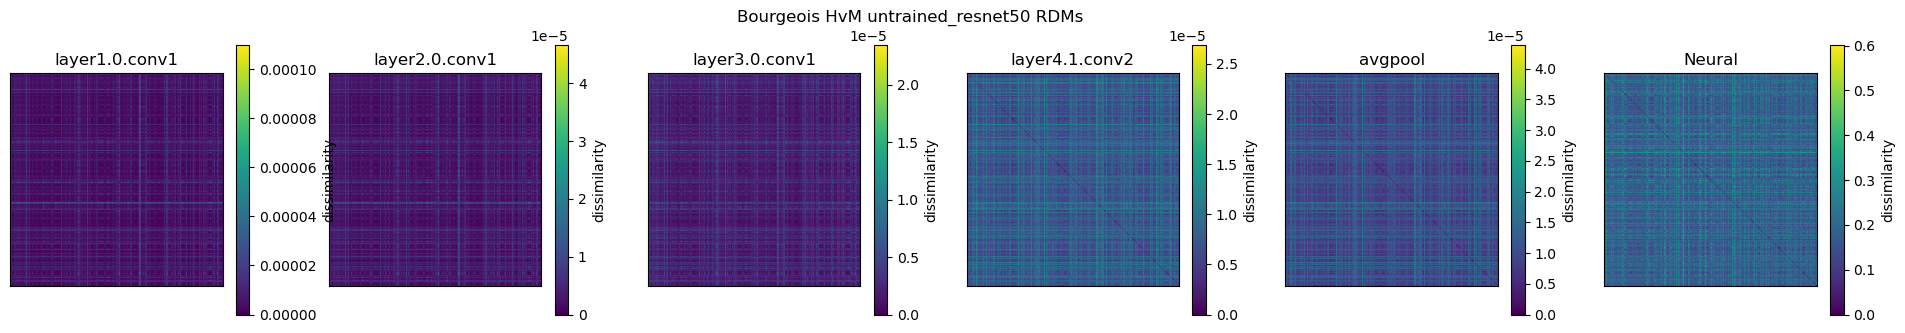

In [107]:
# Compute and save RDMs for each layer
rdm_dict = {label: rdm(resp) for label, resp in resp_dict.items()}

# Plot RDMs
plot_multiple_rdm(rdm_dict)
plt.suptitle(f'{monkey} {imageset} {model_name} RDMs')

# Set title and save
plt.savefig(
    f'/mnt/smb/locker/issa-locker/users/Parsa/marmoset_figures/{imageset}/{monkey}_{model_name}_{notes}RDMs',
    bbox_inches='tight')

In [108]:
# Define correlate_rdms
def correlate_rdms(rdm1, rdm2):
    """Correlate off-diagonal elements of two RDM's
  
    Args:
      rdm1 (np.ndarray): S x S representational dissimilarity matrix
      rdm2 (np.ndarray): S x S representational dissimilarity matrix to
        correlate with rdm1
  
    Returns:
      float: correlation coefficient between the off-diagonal elements
        of rdm1 and rdm2
  
    """
  
    # Extract off-diagonal elements of each RDM
    ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
    rdm1_offdiag = rdm1[ioffdiag]
    rdm2_offdiag = rdm2[ioffdiag]
  
    corr_coef = np.corrcoef(rdm1_offdiag, rdm2_offdiag)[0,1]
  
    return corr_coef

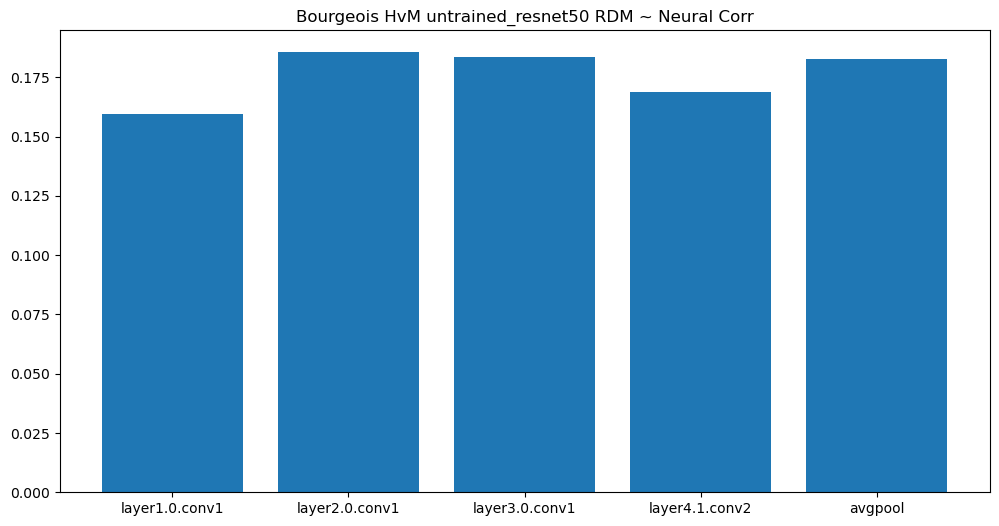

In [109]:
# Compute correlations and save plot
rdm_model = rdm_dict.copy()
rdm_IT = rdm_model.pop('Neural')

# Correlate off-diagonal terms of dissimilarity matrices
rdm_sim = {label: correlate_rdms(rdm_IT, rdm) for label, rdm in rdm_model.items()}
plt.figure(figsize=(12, 6))
plt.bar(rdm_sim.keys(), rdm_sim.values())
plt.title(f'{monkey} {imageset} {model_name} RDM ~ Neural Corr')

plt.savefig(
    f'/mnt/smb/locker/issa-locker/users/Parsa/marmoset_figures/{imageset}/{monkey}_{model_name}_{notes}RDMs_corrs',
    bbox_inches='tight')